In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import hyperdash as hd

%load_ext autoreload

In [ ]:
#'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster', 'item_nbr', 'n_family', 'class', 'perishable'

In [2]:
unit_mean, unit_std = pd.read_csv('data/mean_std.csv', index_col=0).T[0]

In [5]:
df_items['class'].max()

254

In [14]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null int32
n_family      4100 non-null uint32
class         4100 non-null int32
perishable    4100 non-null int8
dtypes: int32(2), int8(1), uint32(1)
memory usage: 52.1 KB


In [4]:
df_stores = pd.read_csv(
    'data/num_stores.csv.gz',
     dtype={
         'store_nbr': np.uint8,
         'n_city': np.uint32,
         'n_state': np.uint32,
         'n_type': np.uint32,
         'cluster': np.uint32
     }

)
df_items = pd.read_csv(
    'data/num_items.csv.gz',
    dtype={
        'item_nbr': np.int32,
        'n_family': np.int32,
        'class': np.int32,
        'perishable': np.int8,
    }
)
for stores_col in ['n_city', 'n_state', 'n_type', 'cluster']:
    df_stores[stores_col] = df_stores[stores_col] - df_stores[stores_col].min()
    
for items_col in ['n_family', 'class', 'perishable']:
    df_items[items_col] = df_items[items_col] - df_items[items_col].min()

In [6]:
%%time
df = pd.read_csv(
    'data/ts.csv.gz',
    parse_dates=[0],
    #nrows=1000000,
    dtype={
        'item_nbr': np.int32,
        'store_nbr': np.int8,
        'unit_sales': np.float32,
        'onpromotion': np.int8,
        'holiday': np.int8,
        'weekend': np.int8,
        'waged_day': np.int8,
        'dow_0': np.int8,
        'dow_1': np.int8,
        'dow_2': np.int8,
        'dow_3': np.int8,
        'dow_4': np.int8,
        'dow_5': np.int8,
        'dow_6': np.int8,
    }
)
df.head()

CPU times: user 5min 34s, sys: 18.3 s, total: 5min 52s
Wall time: 5min 10s


In [7]:
%%time
ts_columns = df.columns[3:]
      
attr_cols = [
    'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster',
    'item_nbr', 'n_family', 'class',
    #'perishable'
]

df_pivot = df.pivot_table(
    index=['store_nbr', 'item_nbr'],
    columns=['date'],
    values=ts_columns
).reset_index()

df_pivot = df_pivot.merge(df_items, on='item_nbr')
df_pivot['store_nbr'] = df_pivot[('store_nbr', '')]
df_pivot = df_pivot.merge(df_stores, on='store_nbr')

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 12min 49s, sys: 2min 43s, total: 15min 32s
Wall time: 12min 14s


In [8]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210654 entries, 0 to 210653
Columns: 9887 entries, item_nbr to cluster
dtypes: float64(823), int32(1), int64(4), int8(9054), uint32(5)
memory usage: 3.1 GB


In [9]:
def get_date_cols(date, history=20, predict_days=16, ts_columns=ts_columns, skip=0):
                  #date, days=1, attr_cols=attr_columns_wo_means, ts_cols=ts_columns, attr=True):
    
    if type(date) != pd.Timestamp:
        date = pd.to_datetime(date)
        
    X_start_date = date - pd.Timedelta('{} days'.format(history-1))
    #X_end_date = date
    y_start_date = date + pd.Timedelta('{} days'.format(skip+1))
    #y_end_date = date + pd.Timedelta('{} days'.format(predict_days))

    X_cols, y_cols, y_day_attr_cols = [], [], []
    
    for d in pd.date_range(X_start_date, periods=history, freq='D'):
        for elem in ts_columns:
            X_cols.append((elem, d))
            
    for d in pd.date_range(y_start_date, periods=predict_days, freq='D'):
        y_cols.append(('unit_sales_scaled', d))
        for elem in ts_columns[1:]:
            y_day_attr_cols.append((elem, d))
            
    return X_cols, y_cols, y_day_attr_cols



X_cols, y_cols, y_day_attr_cols = get_date_cols('2017-08-15', predict_days=5)
    
df_pivot.head().loc[:, y_day_attr_cols]

,"(onpromotion, 2017-08-16 00:00:00)","(holiday, 2017-08-16 00:00:00)","(weekend, 2017-08-16 00:00:00)","(waged_day, 2017-08-16 00:00:00)","(dow_0, 2017-08-16 00:00:00)","(dow_1, 2017-08-16 00:00:00)","(dow_2, 2017-08-16 00:00:00)","(dow_3, 2017-08-16 00:00:00)","(dow_4, 2017-08-16 00:00:00)","(dow_5, 2017-08-16 00:00:00)",...,"(holiday, 2017-08-20 00:00:00)","(weekend, 2017-08-20 00:00:00)","(waged_day, 2017-08-20 00:00:00)","(dow_0, 2017-08-20 00:00:00)","(dow_1, 2017-08-20 00:00:00)","(dow_2, 2017-08-20 00:00:00)","(dow_3, 2017-08-20 00:00:00)","(dow_4, 2017-08-20 00:00:00)","(dow_5, 2017-08-20 00:00:00)","(dow_6, 2017-08-20 00:00:00)"
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [10]:
def get_random_train_test(df_pivot,
        date, window=21, freq=7, size=2000, history=1, predict_days=16, epochs=2, 
        shuffle_dates=True, shuffle_indexes=True, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    
    window = freq * (window//freq)
    num_items = df_pivot.shape[0]
    
    date = pd.to_datetime(date)
    start_window =  date - pd.Timedelta('{} days'.format(window))
    end_date = date
    
    dates = pd.date_range(start=start_window, end=end_date)
    dates = dates[::freq]
    
    print(dates)
    
    patches = []
    #end_X_date = end_date - pd.Timedelta('{} days'.format(label_dates))
    if shuffle_dates and shuffle_indexes:
        permutated_dates = np.random.permutation(dates)
        permutated_indx = np.random.permutation(num_items)   
        for epoch in range(epochs):
            for i in range(num_items//size+1):
                s = size * i
                e = size * (i+1)
                indexes = permutated_indx[s:e]

                for date in permutated_dates:
                    patches.append([indexes, date])

        patches = np.random.permutation(patches)
        
    elif not shuffle_dates and shuffle_indexes:
        permutated_indx = np.random.permutation(num_items)
        for date in dates:
            for epoch in range(epochs):
                for i in range(num_items//size+1):
                    s = size * i
                    e = size * (i+1)
                    indexes = permutated_indx[s:e]
                    patches.append([indexes, date])

    for indexes, date in patches:
        df_pivot_slice = df_pivot.iloc[indexes]
        X_cols, y_cols, y_day_attr_cols = get_date_cols(
            date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
        )

        X = np.array(
            df_pivot_slice.loc[:, X_cols]
        ).reshape([-1, history, len(ts_columns)])

        y_day_attr = np.array(
            df_pivot_slice.loc[:, y_day_attr_cols]
        ).reshape([-1, predict_days, len(ts_columns)-1])
        
        y = np.array(df_pivot_slice.loc[:, y_cols])
        features = [X, y_day_attr, y]
        for feature in attr_cols:
            features.append(
                np.array(df_pivot_slice.loc[:, feature])
            )
        for i in range(len(indexes)):
            yield tuple([elem[i] for elem in features])

tmp = get_random_train_test(df_pivot, '2017-07-15', window=20, history=90, predict_days=5)
tmp1 = next(tmp)
print(tmp1[0].shape, tmp1[1].shape, tmp1[2].shape, tmp1[3].shape)

DatetimeIndex(['2017-07-01', '2017-07-08', '2017-07-15'], dtype='datetime64[ns]', freq='7D')
(90, 12) (5, 11) (5,) ()


In [147]:
for i in range(2000):
    next(tmp)

In [148]:
next(tmp)

(array([[-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ]]), array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8), array([-0.71689729, -0.71689729, -0.71689729, -0.71689729, -0.71689729]), 36, 11, 6, 4, 9, 1960806, 30, 106)

In [11]:
def get_validation(df_pivot,
        date, history=1, predict_days=16, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    X_cols, y_cols, y_day_attr_cols = get_date_cols(
        date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
    )

    X = np.array(
        df_pivot.loc[:, X_cols]
    ).reshape([-1, history, len(ts_columns)])
    
    y_day_attr = np.array(
        df_pivot.loc[:, y_day_attr_cols]
    ).reshape([-1, predict_days, len(ts_columns)-1])

    y = np.array(df_pivot.loc[:, y_cols])
    features = [X, y_day_attr, y]
    for feature in attr_cols:
        features.append(
            np.array(df_pivot.loc[:, feature])
        )

    return features

tmp = get_validation(df_pivot, '2017-07-15', history=90, predict_days=5)
print(tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape)

(210654, 90, 12) (210654, 5, 11) (210654, 5) (210654,)


In [ ]:
%autoreload 2

history = 400
time_to_predict = 16
freq=1

last_day_train = '2017-07-14'
window=300
epochs = 100
validation_day = pd.to_datetime(last_day_train) + pd.Timedelta('{} days'.format(time_to_predict))
batch_size = 1000
sum_W = 3574368.0/16
skip=0

print(validation_day)

batch_gen = get_random_train_test(
    df_pivot,
    last_day_train,
    window=window,
    history=history,
    size=batch_size,
    predict_days=time_to_predict,
    epochs=epochs,
    skip=skip,
    freq=freq
)

val_set = get_validation(df_pivot, validation_day, history=history,
                        predict_days=time_to_predict, skip=skip)

from model import RNNModel

m = RNNModel(
    history=history,
    n_days_predict=time_to_predict,
    clip_gradients=1.,
    starter_learning_rate=0.0001,
    #starter_learning_rate=0.0005,
    n_layers_rnn=1,
    rnn_size_encoder=200,
    rnn_size_decoder=200,
    #output_droupouts_kp=[.9, .9, .9, .95, 1.]
)
print(1)
m.build_graph(batch_gen)


try:
    hd_exp.end()
except NameError:
    pass

hd_exp = hd.Experiment('RNN fav 3')

m.train(val_set, coef=unit_std, sum_W=sum_W,
        report_every=100, validate_every=5000,
        hd_exp=hd_exp)

2017-07-30 00:00:00
1
DatetimeIndex(['2016-09-17', '2016-09-18', '2016-09-19', '2016-09-20',
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26',
               ...
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14'],
              dtype='datetime64[ns]', length=301, freq='D')
g_step: 100 loss std/mean: 0.1579766720533371 0.4370148181915283
| Loss std:   0.157977 |
| Loss mean:   0.437015 |
g_step: 200 loss std/mean: 0.04570454731583595 0.3249939978122711
| Loss std:   0.045705 |
| Loss mean:   0.324994 |
g_step: 300 loss std/mean: 0.040676068514585495 0.31800219416618347
| Loss std:   0.040676 |
| Loss mean:   0.318002 |
g_step: 400 loss std/mean: 0.04791926592588425 0.30429837107658386
| Loss std:   0.047919 |
| Loss mean:   0.304298 |
g_step: 500 loss std/mean: 0.049862090498209 0.30905318260

g_step: 6500 loss std/mean: 0.041622646152973175 0.2753021717071533
| Loss std:   0.041623 |
| Loss mean:   0.275302 |
g_step: 6600 loss std/mean: 0.03317376226186752 0.276874840259552
| Loss std:   0.033174 |
| Loss mean:   0.276875 |
g_step: 6700 loss std/mean: 0.04397613927721977 0.2714592218399048
| Loss std:   0.043976 |
| Loss mean:   0.271459 |
g_step: 6800 loss std/mean: 0.03457670286297798 0.2617335617542267
| Loss std:   0.034577 |
| Loss mean:   0.261734 |
g_step: 6900 loss std/mean: 0.036569323390722275 0.2724702060222626
| Loss std:   0.036569 |
| Loss mean:   0.272470 |
g_step: 7000 loss std/mean: 0.03355363756418228 0.2732163369655609
| Loss std:   0.033554 |
| Loss mean:   0.273216 |
g_step: 7100 loss std/mean: 0.031359199434518814 0.27818459272384644
| Loss std:   0.031359 |
| Loss mean:   0.278185 |
g_step: 7200 loss std/mean: 0.02797783724963665 0.2699315547943115
| Loss std:   0.027978 |
| Loss mean:   0.269932 |
g_step: 7300 loss std/mean: 0.03592121973633766 0.265

| Loss mean:   0.267829 |
g_step: 13300 loss std/mean: 0.0294482558965683 0.25652235746383667
| Loss std:   0.029448 |
| Loss mean:   0.256522 |
g_step: 13400 loss std/mean: 0.03435644507408142 0.2571505308151245
| Loss std:   0.034356 |
| Loss mean:   0.257151 |
g_step: 13500 loss std/mean: 0.031202297657728195 0.2664894759654999
| Loss std:   0.031202 |
| Loss mean:   0.266489 |
g_step: 13600 loss std/mean: 0.026705248281359673 0.2690742611885071
| Loss std:   0.026705 |
| Loss mean:   0.269074 |
g_step: 13700 loss std/mean: 0.02668011374771595 0.2613024115562439
| Loss std:   0.026680 |
| Loss mean:   0.261302 |
g_step: 13800 loss std/mean: 0.02744857594370842 0.2662462294101715
| Loss std:   0.027449 |
| Loss mean:   0.266246 |
g_step: 13900 loss std/mean: 0.02704527974128723 0.26076042652130127
| Loss std:   0.027045 |
| Loss mean:   0.260760 |
g_step: 14000 loss std/mean: 0.0253080315887928 0.26612958312034607
| Loss std:   0.025308 |
| Loss mean:   0.266130 |
g_step: 14100 loss 

g_step: 20000 loss std/mean: 0.025669679045677185 0.25130757689476013
| Loss std:   0.025670 |
| Loss mean:   0.251308 |
	Validation NWRMSLE  : 0.53310310255
| Validation NWRMSLE:   0.533103 |
	Validation NWRMSLE_5: 0.525374662044
| Validation NWRMSLE_5:   0.525375 |
g_step: 20100 loss std/mean: 0.023248976096510887 0.25464722514152527
| Loss std:   0.023249 |
| Loss mean:   0.254647 |
g_step: 20200 loss std/mean: 0.02545763924717903 0.2555767297744751
| Loss std:   0.025458 |
| Loss mean:   0.255577 |
g_step: 20300 loss std/mean: 0.023554623126983643 0.2564777731895447
| Loss std:   0.023555 |
| Loss mean:   0.256478 |
g_step: 20400 loss std/mean: 0.023549240082502365 0.25736692547798157
| Loss std:   0.023549 |
| Loss mean:   0.257367 |
g_step: 20500 loss std/mean: 0.020828647539019585 0.25658121705055237
| Loss std:   0.020829 |
| Loss mean:   0.256581 |
g_step: 20600 loss std/mean: 0.025560157373547554 0.2576771676540375
| Loss std:   0.025560 |
| Loss mean:   0.257677 |
g_step: 20

g_step: 26600 loss std/mean: 0.025882622227072716 0.24664218723773956
| Loss std:   0.025883 |
| Loss mean:   0.246642 |
g_step: 26700 loss std/mean: 0.024124804884195328 0.2576996684074402
| Loss std:   0.024125 |
| Loss mean:   0.257700 |
g_step: 26800 loss std/mean: 0.028136951848864555 0.2524099051952362
| Loss std:   0.028137 |
| Loss mean:   0.252410 |
g_step: 26900 loss std/mean: 0.025517644360661507 0.2563152015209198
| Loss std:   0.025518 |
| Loss mean:   0.256315 |
g_step: 27000 loss std/mean: 0.026503723114728928 0.2549471855163574
| Loss std:   0.026504 |
| Loss mean:   0.254947 |
g_step: 27100 loss std/mean: 0.02760527841746807 0.25202009081840515
| Loss std:   0.027605 |
| Loss mean:   0.252020 |
g_step: 27200 loss std/mean: 0.02261299081146717 0.2551206648349762
| Loss std:   0.022613 |
| Loss mean:   0.255121 |
g_step: 27300 loss std/mean: 0.023287879303097725 0.25372493267059326
| Loss std:   0.023288 |
| Loss mean:   0.253725 |
g_step: 27400 loss std/mean: 0.02693044

| Loss mean:   0.251665 |
g_step: 33400 loss std/mean: 0.02534199133515358 0.2575969994068146
| Loss std:   0.025342 |
| Loss mean:   0.257597 |
g_step: 33500 loss std/mean: 0.02331063151359558 0.2482290416955948
| Loss std:   0.023311 |
| Loss mean:   0.248229 |
g_step: 33600 loss std/mean: 0.020680630579590797 0.25032174587249756
| Loss std:   0.020681 |
| Loss mean:   0.250322 |
g_step: 33700 loss std/mean: 0.028685256838798523 0.2533373236656189
| Loss std:   0.028685 |
| Loss mean:   0.253337 |
g_step: 33800 loss std/mean: 0.02306191809475422 0.2593108117580414
| Loss std:   0.023062 |
| Loss mean:   0.259311 |
g_step: 33900 loss std/mean: 0.024264724925160408 0.2503112554550171
| Loss std:   0.024265 |
| Loss mean:   0.250311 |
g_step: 34000 loss std/mean: 0.02445239946246147 0.25311583280563354
| Loss std:   0.024452 |
| Loss mean:   0.253116 |
g_step: 34100 loss std/mean: 0.027046842500567436 0.25233736634254456
| Loss std:   0.027047 |
| Loss mean:   0.252337 |
g_step: 34200 l

	Validation NWRMSLE  : 0.530075113956
| Validation NWRMSLE:   0.530075 |
	Validation NWRMSLE_5: 0.52380067133
| Validation NWRMSLE_5:   0.523801 |
g_step: 40100 loss std/mean: 0.026062587276101112 0.25317543745040894
| Loss std:   0.026063 |
| Loss mean:   0.253175 |
g_step: 40200 loss std/mean: 0.02664034813642502 0.24997611343860626
| Loss std:   0.026640 |
| Loss mean:   0.249976 |
g_step: 40300 loss std/mean: 0.022538065910339355 0.2558690011501312
| Loss std:   0.022538 |
| Loss mean:   0.255869 |
g_step: 40400 loss std/mean: 0.023015109822154045 0.25057804584503174
| Loss std:   0.023015 |
| Loss mean:   0.250578 |
g_step: 40500 loss std/mean: 0.022171765565872192 0.25676825642585754
| Loss std:   0.022172 |
| Loss mean:   0.256768 |
g_step: 40600 loss std/mean: 0.024117982015013695 0.25808092951774597
| Loss std:   0.024118 |
| Loss mean:   0.258081 |
g_step: 40700 loss std/mean: 0.0240859966725111 0.25300344824790955
| Loss std:   0.024086 |
| Loss mean:   0.253003 |
g_step: 40

| Loss mean:   0.251621 |
g_step: 46700 loss std/mean: 0.021038375794887543 0.25452762842178345
| Loss std:   0.021038 |
| Loss mean:   0.254528 |
g_step: 46800 loss std/mean: 0.023625513538718224 0.2557239830493927
| Loss std:   0.023626 |
| Loss mean:   0.255724 |
g_step: 46900 loss std/mean: 0.020467324182391167 0.25802624225616455
| Loss std:   0.020467 |
| Loss mean:   0.258026 |
g_step: 47000 loss std/mean: 0.025104191154241562 0.25462740659713745
| Loss std:   0.025104 |
| Loss mean:   0.254627 |
g_step: 47100 loss std/mean: 0.02593192458152771 0.2577325105667114
| Loss std:   0.025932 |
| Loss mean:   0.257733 |
g_step: 47200 loss std/mean: 0.024249451234936714 0.2543759047985077
| Loss std:   0.024249 |
| Loss mean:   0.254376 |
g_step: 47300 loss std/mean: 0.02295958250761032 0.2567659616470337
| Loss std:   0.022960 |
| Loss mean:   0.256766 |
g_step: 47400 loss std/mean: 0.021491294726729393 0.25092747807502747
| Loss std:   0.021491 |
| Loss mean:   0.250927 |
g_step: 4750

g_step: 53400 loss std/mean: 0.0262470543384552 0.25015994906425476
| Loss std:   0.026247 |
| Loss mean:   0.250160 |
g_step: 53500 loss std/mean: 0.020961543545126915 0.25078240036964417
| Loss std:   0.020962 |
| Loss mean:   0.250782 |
g_step: 53600 loss std/mean: 0.027335215359926224 0.25263237953186035
| Loss std:   0.027335 |
| Loss mean:   0.252632 |
g_step: 53700 loss std/mean: 0.0227176696062088 0.25193557143211365
| Loss std:   0.022718 |
| Loss mean:   0.251936 |
g_step: 53800 loss std/mean: 0.022593991830945015 0.24963515996932983
| Loss std:   0.022594 |
| Loss mean:   0.249635 |
g_step: 53900 loss std/mean: 0.027164718136191368 0.257296621799469
| Loss std:   0.027165 |
| Loss mean:   0.257297 |
g_step: 54000 loss std/mean: 0.021746546030044556 0.2524465322494507
| Loss std:   0.021747 |
| Loss mean:   0.252447 |
g_step: 54100 loss std/mean: 0.02616732381284237 0.24856549501419067
| Loss std:   0.026167 |
| Loss mean:   0.248565 |
g_step: 54200 loss std/mean: 0.021513847

	Validation NWRMSLE  : 0.530039105911
| Validation NWRMSLE:   0.530039 |
	Validation NWRMSLE_5: 0.524543318551
| Validation NWRMSLE_5:   0.524543 |
g_step: 60100 loss std/mean: 0.026219502091407776 0.25146016478538513
| Loss std:   0.026220 |
| Loss mean:   0.251460 |
g_step: 60200 loss std/mean: 0.020909879356622696 0.2562668025493622
| Loss std:   0.020910 |
| Loss mean:   0.256267 |
g_step: 60300 loss std/mean: 0.025175604969263077 0.2577967643737793
| Loss std:   0.025176 |
| Loss mean:   0.257797 |
g_step: 60400 loss std/mean: 0.02296043373644352 0.2503468096256256
| Loss std:   0.022960 |
| Loss mean:   0.250347 |
g_step: 60500 loss std/mean: 0.02046113647520542 0.2485845983028412
| Loss std:   0.020461 |
| Loss mean:   0.248585 |
g_step: 60600 loss std/mean: 0.02881862223148346 0.2492980808019638
| Loss std:   0.028819 |
| Loss mean:   0.249298 |
g_step: 60700 loss std/mean: 0.021314486861228943 0.2556174695491791
| Loss std:   0.021314 |
| Loss mean:   0.255617 |
g_step: 60800 

g_step: 66700 loss std/mean: 0.02154172584414482 0.2500375211238861
| Loss std:   0.021542 |
| Loss mean:   0.250038 |
g_step: 66800 loss std/mean: 0.02042596973478794 0.24964767694473267
| Loss std:   0.020426 |
| Loss mean:   0.249648 |
g_step: 66900 loss std/mean: 0.025827603414654732 0.2461906373500824
| Loss std:   0.025828 |
| Loss mean:   0.246191 |
g_step: 67000 loss std/mean: 0.024887938052415848 0.24513158202171326
| Loss std:   0.024888 |
| Loss mean:   0.245132 |
g_step: 67100 loss std/mean: 0.022903846576809883 0.2497907429933548
| Loss std:   0.022904 |
| Loss mean:   0.249791 |
g_step: 67200 loss std/mean: 0.022419452667236328 0.2540939450263977
| Loss std:   0.022419 |
| Loss mean:   0.254094 |
g_step: 67300 loss std/mean: 0.026234524324536324 0.24561342597007751
| Loss std:   0.026235 |
| Loss mean:   0.245613 |
g_step: 67400 loss std/mean: 0.022882843390107155 0.2533265948295593
| Loss std:   0.022883 |
| Loss mean:   0.253327 |
g_step: 67500 loss std/mean: 0.02503925

g_step: 73400 loss std/mean: 0.021789170801639557 0.2529124617576599
| Loss std:   0.021789 |
| Loss mean:   0.252912 |
g_step: 73500 loss std/mean: 0.024475954473018646 0.25587233901023865
| Loss std:   0.024476 |
| Loss mean:   0.255872 |
g_step: 73600 loss std/mean: 0.025400906801223755 0.24891433119773865
| Loss std:   0.025401 |
| Loss mean:   0.248914 |
g_step: 73700 loss std/mean: 0.020431270822882652 0.2470746487379074
| Loss std:   0.020431 |
| Loss mean:   0.247075 |
g_step: 73800 loss std/mean: 0.022937290370464325 0.2504267394542694
| Loss std:   0.022937 |
| Loss mean:   0.250427 |
g_step: 73900 loss std/mean: 0.024051383137702942 0.24903792142868042
| Loss std:   0.024051 |
| Loss mean:   0.249038 |
g_step: 74000 loss std/mean: 0.028399091213941574 0.25184765458106995
| Loss std:   0.028399 |
| Loss mean:   0.251848 |
g_step: 74100 loss std/mean: 0.02974245697259903 0.24804405868053436
| Loss std:   0.029742 |
| Loss mean:   0.248044 |
g_step: 74200 loss std/mean: 0.02384

	Validation NWRMSLE  : 0.529416793628
| Validation NWRMSLE:   0.529417 |
	Validation NWRMSLE_5: 0.523491194692
| Validation NWRMSLE_5:   0.523491 |
g_step: 80100 loss std/mean: 0.022306036204099655 0.2494547814130783
| Loss std:   0.022306 |
| Loss mean:   0.249455 |
g_step: 80200 loss std/mean: 0.023917226120829582 0.25340694189071655
| Loss std:   0.023917 |
| Loss mean:   0.253407 |
g_step: 80300 loss std/mean: 0.022553790360689163 0.2448974996805191
| Loss std:   0.022554 |
| Loss mean:   0.244897 |
g_step: 80400 loss std/mean: 0.023822568356990814 0.24967649579048157
| Loss std:   0.023823 |
| Loss mean:   0.249676 |
g_step: 80500 loss std/mean: 0.02704465016722679 0.24409198760986328
| Loss std:   0.027045 |
| Loss mean:   0.244092 |
g_step: 80600 loss std/mean: 0.02467367611825466 0.24342837929725647
| Loss std:   0.024674 |
| Loss mean:   0.243428 |
g_step: 80700 loss std/mean: 0.02126428671181202 0.2554239332675934
| Loss std:   0.021264 |
| Loss mean:   0.255424 |
g_step: 808

| Loss mean:   0.254081 |
g_step: 86700 loss std/mean: 0.01995071955025196 0.25402212142944336
| Loss std:   0.019951 |
| Loss mean:   0.254022 |
g_step: 86800 loss std/mean: 0.027252938598394394 0.2564069926738739
| Loss std:   0.027253 |
| Loss mean:   0.256407 |
g_step: 86900 loss std/mean: 0.021259967237710953 0.25084078311920166
| Loss std:   0.021260 |
| Loss mean:   0.250841 |
g_step: 87000 loss std/mean: 0.026380516588687897 0.2512950599193573
| Loss std:   0.026381 |
| Loss mean:   0.251295 |
g_step: 87100 loss std/mean: 0.025337805971503258 0.2513958811759949
| Loss std:   0.025338 |
| Loss mean:   0.251396 |
g_step: 87200 loss std/mean: 0.025482237339019775 0.256461501121521
| Loss std:   0.025482 |
| Loss mean:   0.256462 |
g_step: 87300 loss std/mean: 0.021205488592386246 0.2489703893661499
| Loss std:   0.021205 |
| Loss mean:   0.248970 |
g_step: 87400 loss std/mean: 0.024178529158234596 0.24942512810230255
| Loss std:   0.024179 |
| Loss mean:   0.249425 |
g_step: 87500

| Loss mean:   0.254047 |
g_step: 93400 loss std/mean: 0.024459155276417732 0.2579696774482727
| Loss std:   0.024459 |
| Loss mean:   0.257970 |
g_step: 93500 loss std/mean: 0.022435927763581276 0.24780669808387756
| Loss std:   0.022436 |
| Loss mean:   0.247807 |
g_step: 93600 loss std/mean: 0.024571087211370468 0.2495572715997696
| Loss std:   0.024571 |
| Loss mean:   0.249557 |
g_step: 93700 loss std/mean: 0.021389134228229523 0.24993625283241272
| Loss std:   0.021389 |
| Loss mean:   0.249936 |
g_step: 93800 loss std/mean: 0.025005506351590157 0.2537928819656372
| Loss std:   0.025006 |
| Loss mean:   0.253793 |
g_step: 93900 loss std/mean: 0.024866560474038124 0.25524741411209106
| Loss std:   0.024867 |
| Loss mean:   0.255247 |
g_step: 94000 loss std/mean: 0.020660294219851494 0.24937331676483154
| Loss std:   0.020660 |
| Loss mean:   0.249373 |
g_step: 94100 loss std/mean: 0.025471478700637817 0.2543089985847473
| Loss std:   0.025471 |
| Loss mean:   0.254309 |
g_step: 94

	Validation NWRMSLE  : 0.529352206375
| Validation NWRMSLE:   0.529352 |
	Validation NWRMSLE_5: 0.523689273415
| Validation NWRMSLE_5:   0.523689 |
g_step: 100100 loss std/mean: 0.021566787734627724 0.25157320499420166
| Loss std:   0.021567 |
| Loss mean:   0.251573 |
g_step: 100200 loss std/mean: 0.023948626592755318 0.24661043286323547
| Loss std:   0.023949 |
| Loss mean:   0.246610 |
g_step: 100300 loss std/mean: 0.023883674293756485 0.24974052608013153
| Loss std:   0.023884 |
| Loss mean:   0.249741 |
g_step: 100400 loss std/mean: 0.02341749332845211 0.25601282715797424
| Loss std:   0.023417 |
| Loss mean:   0.256013 |
g_step: 100500 loss std/mean: 0.02006395533680916 0.25887733697891235
| Loss std:   0.020064 |
| Loss mean:   0.258877 |
g_step: 100600 loss std/mean: 0.023910269141197205 0.2510247528553009
| Loss std:   0.023910 |
| Loss mean:   0.251025 |
g_step: 100700 loss std/mean: 0.025125427171587944 0.2477564960718155
| Loss std:   0.025125 |
| Loss mean:   0.247756 |
g_

| Loss mean:   0.250938 |
g_step: 106700 loss std/mean: 0.021789003163576126 0.25502753257751465
| Loss std:   0.021789 |
| Loss mean:   0.255028 |
g_step: 106800 loss std/mean: 0.02033606544137001 0.2528955638408661
| Loss std:   0.020336 |
| Loss mean:   0.252896 |
g_step: 106900 loss std/mean: 0.025689905509352684 0.24953113496303558
| Loss std:   0.025690 |
| Loss mean:   0.249531 |
g_step: 107000 loss std/mean: 0.026551781222224236 0.24674884974956512
| Loss std:   0.026552 |
| Loss mean:   0.246749 |
g_step: 107100 loss std/mean: 0.023300088942050934 0.25213801860809326
| Loss std:   0.023300 |
| Loss mean:   0.252138 |
g_step: 107200 loss std/mean: 0.025883972644805908 0.25308334827423096
| Loss std:   0.025884 |
| Loss mean:   0.253083 |
g_step: 107300 loss std/mean: 0.02372504211962223 0.2534681558609009
| Loss std:   0.023725 |
| Loss mean:   0.253468 |
g_step: 107400 loss std/mean: 0.02885463275015354 0.24865800142288208
| Loss std:   0.028855 |
| Loss mean:   0.248658 |
g_s

In [31]:
sales = df[
    (df['item_nbr'] == 1503844) &
    (df['store_nbr'] == 44) 
    
]['unit_sales_scaled']

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

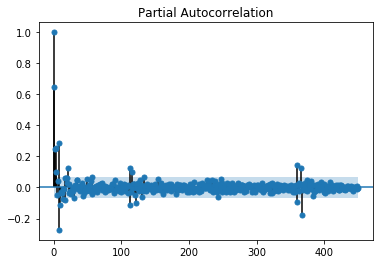

In [33]:
sm.graphics.tsa.plot_pacf(sales, lags=450)
plt.show()

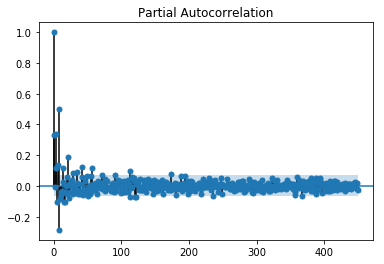

In [49]:
sales2, tmp = stats.boxcox((sales+unit_mean))
sm.graphics.tsa.plot_pacf(sales2, lags=450)
plt.show()